# Automated ML

### Libraries


In [3]:
# AzureML
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.automl.run import AutoMLRun
from azureml.core.model import Model, InferenceConfig
from azureml.core.environment import Environment
from azureml.core.webservice import AciWebservice

# Webservice
import urllib.request
import json
import os
import ssl

# Data Manipulation
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


## Dataset

### Overview

The dataset used for this experiment will be an opensource univariate dataset provided by the San Francisco International Airport (SFO). The dataset contains all informations on Monthly Passenger Traffic at the airport since July 2005.

More informations about the dataset can be found here : https://data.sfgov.org/Transportation/Air-Traffic-Passenger-Statistics/rkru-6vcg

The main goal of the experiment will be to see the impact of the COVID19 on passenger traffic at SFO. We are going to compare forecast data train on the dataset before Covid and compare it to actual data from march 2020 to September 2020.

AutoML forecasting task will be used to try to find the best model to predict the number of passenger.

In [4]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'SFO-Traffic-Predictions'

experiment=Experiment(ws, experiment_name)


In [5]:
# import the dataset into a DataFrame
df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [6]:
# Add a date column in a datetime format in order to use it as an date index
df['date'] = pd.to_datetime(df['Activity Period'], format = '%Y%m')

# Select only two columns Date and Passenger Count to prepare the forecasting task
# We want to group all passenger by date regardless of any other features
df_clean = df[['date','Passenger Count']].groupby('date').sum()

# Let's have a look at the last 10 months. We can see a drop in passenger count beginning in March 2020.
df_clean.tail(10)


,Passenger Count
date,
2019-12-01,4720992
2020-01-01,4241751
2020-02-01,3742224
2020-03-01,1885466
2020-04-01,138817
2020-05-01,286570
2020-06-01,555119
2020-07-01,765274
2020-08-01,852578


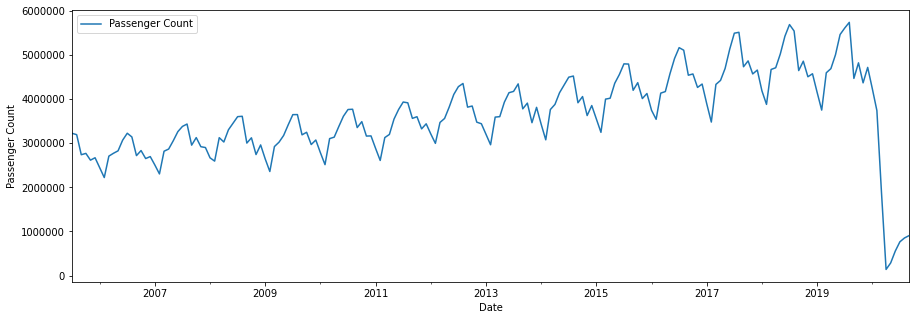

In [7]:
# We can visualize the drop with a line plot

f, ax1 = plt.subplots(1,1,figsize=(15,5))
df_clean.plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Passenger Count")
ax1.ticklabel_format(axis='y', style= 'plain')

In [8]:
# Now we have to split the dataset into PreCovid (<= February 2020) and Covid (after February 2020)

# Reset the index

X = df_clean.reset_index(inplace=False)


# Split the dataframe 
split_date ='2020-02-01'
X_precovid = X.loc[X['date'] <= split_date]
X_covid = X.loc[X['date'] > split_date]


X_precovid.set_index('date', inplace=True)
X_covid.set_index('date', inplace=True)

X_covid

,Passenger Count
date,
2020-03-01,1885466
2020-04-01,138817
2020-05-01,286570
2020-06-01,555119
2020-07-01,765274
2020-08-01,852578
2020-09-01,905992


In [9]:
# Now that we have 2 dataset, we can register them into Azure ML

UPDATE_DATASET = True

if UPDATE_DATASET:    

    path = 'data'

    try:
        os.mkdir(path,)
    except OSError as err:
        print(err)
    else:
        print('Directory %s succesfully created' %path)


    local_path = './data/SFO_prepared.csv'
    local_path_covid = './data/SFO_covid.csv'

    # Save the two dataset to csv
    X_precovid.to_csv(local_path)
    X_covid.to_csv(local_path_covid)


    # upload the local file to a datastore on the cloud

    # get the datastore to upload prepared data
    datastore = ws.get_default_datastore()

    # upload the local file from src_dir to the target_path in datastore
    datastore.upload(src_dir='data', target_path='data', overwrite=True, show_progress=True)

    # create a dataset referencing the cloud location
    dataset_prepared = Dataset.Tabular.from_delimited_files(path = [(datastore, (local_path))])
    dataset_covid = Dataset.Tabular.from_delimited_files(path = [(datastore, (local_path_covid))])


    # Register the Dataset

    dataset_prepared = dataset_prepared.register(workspace=ws,
                                     name='SFO Air Traffic cleaned',
                                     description='SFO Air Traffic predictions cleaned',
                                     create_new_version=True)

    dataset_covid = dataset_covid.register(workspace=ws,
                                     name='SFO Air Traffic covid',
                                     description='SFO Air Traffic predictions covid',
                                     create_new_version=True)

if not UPDATE_DATASET:
    dataset_prepared = Dataset.get_by_name(ws, name='SFO Air Traffic cleaned')
    dataset_covid = Dataset.get_by_name(ws, name='SFO Air Traffic covid')

df_prepared = dataset_prepared.to_pandas_dataframe()
df_prepared = df_prepared.set_index('date', inplace=False)
    
df_covid = dataset_covid.to_pandas_dataframe()
df_covid = df_covid.set_index('date', inplace=False)

# add february 2020 to the Covid dataframe
date = pd.to_datetime("2020-02-01", format = '%Y-%m-%d')

df_covid = df_covid.append(pd.DataFrame({'Passenger Count': 3742224}, index=[date]),verify_integrity=True).rename_axis('date')
df_covid.sort_index(inplace=True)

Directory data succesfully created
Uploading an estimated of 2 files
Uploading data/SFO_covid.csv
Uploaded data/SFO_covid.csv, 1 files out of an estimated total of 2
Uploading data/SFO_prepared.csv
Uploaded data/SFO_prepared.csv, 2 files out of an estimated total of 2
Uploaded 2 files


In [10]:
# Check the dataset
dataset_prepared

{
  "source": [
    "('workspaceblobstore', './data/SFO_prepared.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "4bced22e-3fb1-4862-8f4b-98047572e632",
    "name": "SFO Air Traffic cleaned",
    "version": 1,
    "description": "SFO Air Traffic predictions cleaned",
    "workspace": "Workspace.create(name='quick-starts-ws-139688', subscription_id='f9d5a085-54dc-4215-9ba6-dad5d86e60a0', resource_group='aml-quickstarts-139688')"
  }
}

In [11]:
# Check the DataFrame
df_prepared.tail()

,Passenger Count
date,
2019-10-01,4824559
2019-11-01,4370463
2019-12-01,4720992
2020-01-01,4241751
2020-02-01,3742224


## Compute Configuration

In [14]:
# Choose a name for your CPU cluster
amlcompute_cluster_name = "AMLTraining"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS3_V2',                                                           
                                                           max_nodes=4,
                                                          min_nodes = 1, idle_seconds_before_scaledown = 600)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)
# For a more detailed view of current AmlCompute status, use get_status().

Creating
Succeeded..................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

The goal is to predict the number of passenger at SFO after February 2020 and compare it to the actual data in order to analyse the impact of Covid on the air traffic.

The task we are going to use is a forecasting task. We have to specify the time column and the y column. The other parameter are standard, we will use normalized RMSE as a primary metric to optimize and a cross validation of 5. For forecasting, we use Rolling Origin Cross Validation.

More information on ROCV can be found here : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-forecast#training-and-validation-data

enable_dnn is set to false (by default) because I want to test dnn with Hyperdrive instead of autoML.

target_lags, feature_lags and target_rolling_window_size are set to None.

forecast_horizon is set to 1.

From the doc : 
Minimum historic data required: (2x forecast_horizon) + #n_cross_validations + max(max(target_lags), target_rolling_window_size)

Minimum historic data required = 2 *1 + 5 = 7


In [15]:
automl_settings = {
    "experiment_timeout_minutes":60,
    "max_concurrent_iterations":4,
    "primary_metric": 'normalized_root_mean_squared_error',
    'time_column_name': 'date'
}

automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "forecasting",
                             training_data=dataset_prepared,
                             label_column_name="Passenger Count",
                             enable_early_stopping= True,
                             n_cross_validations=5,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )



In [16]:
# Submit the experiment
TRAIN = True

if TRAIN:
    run_autoML = experiment.submit(automl_config, show_output = True)
    run_autoML.wait_for_completion()
    
# If we already did the training, we can get our run by passing the run_id.
else:
    run_autoML = AutoMLRun(experiment, 'AutoML_71b33a45-fd33-4248-ad2c-f228c393967c')

Running on remote.
No run_configuration provided, running on AMLTraining with default configuration
Running on remote compute: AMLTraining
Parent Run ID: AutoML_a92b16cf-c39d-4c85-ae4e-fbf279c4e01c

Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

*******************************************************************************

## Run Details

In the cell below, use the `RunDetails` widget to show the different experiments.

VotingEnsemble was the best run for this experiment followed by a DecisionTree and a GradientBoosting model. Prophet and AutoArima performed significaly worst probably because of my autoML setting. I will have to have a better look at the way to use these model more efficiently with autoML.

In [17]:
RunDetails(run_autoML).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model

In the cell below, get the best model from the automl experiments and display all the properties of the model.


In [18]:
# Retrieve and save your best automl model.

best_run_autoML, fitted_model_autoML = run_autoML.get_output()

print(best_run_autoML.id)

print('MAE of best autoML model = {} and RMSE = {}'.format(best_run_autoML.get_metrics()['mean_absolute_error'], best_run_autoML.get_metrics()['root_mean_squared_error']))

AutoML_a92b16cf-c39d-4c85-ae4e-fbf279c4e01c_36
MAE of best autoML model = 87028.4616923077 and RMSE = 87028.4616923077


In [28]:
fitted_model_autoML.steps[-1]

('prefittedsoftvotingregressor',
 PreFittedSoftVotingRegressor(estimators=[('10',
                                           Pipeline(memory=None,
                                                    steps=[('standardscalerwrapper',
                                                            <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f3c947cc128>),
                                                           ('decisiontreeregressor',
                                                            DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                  criterion='friedman_mse',
                                                                                  max_depth=None,
                                                                                  max_features=0.8,
                                                                                  max_leaf_nodes=None,
                     

In [19]:
# Save the best model and print the outputs

os.makedirs('outputs/AutoML', exist_ok=True)

best_run_autoML.download_files(prefix='./outputs/', output_directory='outputs/AutoML/')

!ls ./outputs/AutoML/Outputs


conda_env_v_1_0_0.yml		     model.pkl
env_dependencies.json		     pipeline_graph.json
internal_cross_validated_models.pkl  scoring_file_v_1_0_0.py


In [20]:
# Register the best model or load the last one registered

UPDATE_MODEL = True 

if UPDATE_MODEL:
    description = 'Best AutoML Model for Air Traffic Predictions'
    model = run_autoML.register_model(description = description, model_name = 'SFOAutoML',
                               tags={'area': 'SFO Air Traffic Predictions'})

else:
    model = Model(ws,'AutoML71b33a45f35')
    

print(model.id)

SFOAutoML:1


## Model Deployment

The autoML model performed better than the one I got with the hyperdrive DNN notebook so far so I'm going to deploy this version.

In the cell below, I will register the model, create an inference config and deploy the model as a web service.

In [21]:
service_name = 'sfo-prediction-automl'

# Create an inference config from the autoML output files
inference_config = InferenceConfig(entry_script='scoring_file_v_1_0_0.py',
                                  conda_file = 'conda_env_v_1_0_0.yml',
                                  source_directory='./outputs/AutoML/Outputs',
                                  description='ACI for SFO passengers prediction',
                                  runtime='python'
                                  )

# Create a deployment config with an Azure Container Instance
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, auth_enabled=True)

# Deploy the model and check the deployment status
service = Model.deploy(workspace=ws,
                      name=service_name,
                      models=[model],
                      inference_config=inference_config,
                      deployment_config=aci_config
                      )

service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.............................................................................................

.......................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In the cell below, we send a request to the web service you deployed to test it.

In [22]:
# This code is based on the sample code to consume the endpoint provided by Azure ML

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

data = {
    "data":
    [
        {
            'date': "2020-03-01 00:00:00,000000",
        },
        {
            'date': "2020-04-01 00:00:00,000000",
        },
        {
            'date': "2020-05-01 00:00:00,000000",
        },
        {
            'date': "2020-06-01 00:00:00,000000",
        },
        {
            'date': "2020-07-01 00:00:00,000000",
        },
        {
            'date': "2020-08-01 00:00:00,000000",
        },
        {
            'date': "2020-09-01 00:00:00,000000",
        }
    ],
}

body = str.encode(json.dumps(data))

url = service.scoring_uri
api_key, api_key_secondary = service.get_keys() # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
#     print(result)
    y = json.loads(json.loads(result))
    print('For March 2020, the SFO passenger predictions is {}'.format(y['forecast'][0]))
    
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))


For March 2020, the SFO passenger predictions is 4549574.716923077


In [23]:
# plot Actual vs Predicted to watch the impact of Covid from March to September 2020
df_prediction = df_covid.copy()
df_prediction.reset_index(inplace=True)
split_date ='2020-02-02'
df_prediction =df_prediction.loc[df_prediction['date'] <= split_date]
df_prediction.set_index('date', inplace=True)
print(df_prediction)

# Parse the result from the webservice request and create a DataFrame to plot it later
for i in range(len(data['data'][:])):
#     print(data['data'][i]['date'][:10])
    date = pd.to_datetime(data['data'][i]['date'][:10], format = '%Y-%m-%d')
#     print(pd.DataFrame({'Passenger Count': y['forecast'][i]}, index=[date]))
    df_prediction = df_prediction.append(pd.DataFrame({'Passenger Count': y['forecast'][i]}, index=[date]))

df_prediction.sort_index(inplace=True)

print(df_prediction)


            Passenger Count
date                       
2020-02-01          3742224
            Passenger Count
2020-02-01       3742224.00
2020-03-01       4549574.72
2020-04-01       4657438.60
2020-05-01       4962903.76
2020-06-01       5245136.63
2020-07-01       5535507.56
2020-08-01       5633351.44
2020-09-01       4634678.25


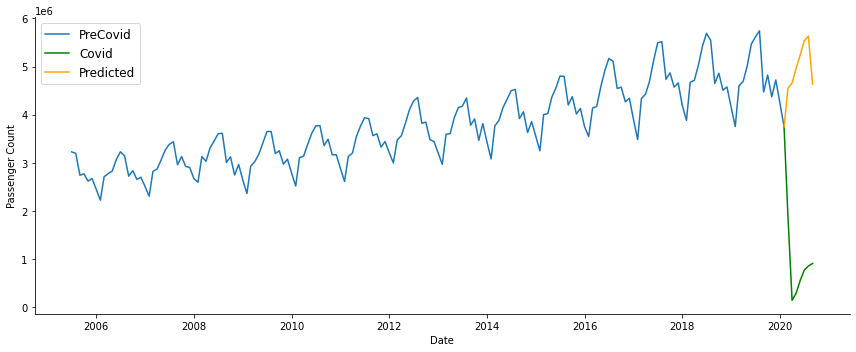

In [24]:
# We can visualize the drop with a line plot

f, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(df_prepared, label='PreCovid')
ax.plot(df_covid, label='Covid', color = 'green')
ax.plot(df_prediction, label='Predicted', color = 'orange')
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count")
ax.legend()
# plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=12)
sns.despine(top=True)


In the cell below, we print the logs of the web service and delete the service

In [25]:
# Print the logs

print(service.get_logs())

2021-03-02T01:38:53,870847400+00:00 - gunicorn/run 
2021-03-02T01:38:53,877967800+00:00 - rsyslog/run 
rsyslogd: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libuuid.so.1: no version information available (required by rsyslogd)
2021-03-02T01:38:53,911809900+00:00 - iot-server/run 
2021-03-02T01:38:53,933581800+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_6f3791fe7434448b4ebe2b0fd691d644/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml

In [26]:
# Delete the endpoint

service.delete()

In [27]:
# Delete the compute

compute_target.delete()